# Implementing entangling gates on a quantum computer

## Setup

First, make sure that you have the latest version of Qiskit installed. To upgrade your Qiskit package, run the following command:

```bash
pip install --upgrade qiskit
```

Get an API key from IonQ. This will be used by the IonQ provider inside Qiskit to submit circuits to the IonQ platform.

After securing an API key, install the python package `qiskit_ionq` using `pip`:

```bash
pip install qiskit_ionq
```

(IonQ's adapter for Qiskit is currently in private beta -- your feedback is welcomed!)

### (Optional) Extra Dependencies

Some examples use additional Python dependencies; please make sure to `pip install` them as needed.

Dependencies:
* `matplotlib`: To run `qiskit.visualization.plot_histogram`.

**NOTE**: The provider expects an API key to be supplied via the `token` keyword argument to its constructor. If no token is directly provided, the provider will check for one in the `QISKIT_IONQ_API_TOKEN` environment variable.

Now that the Python package has been installed, you can import and instantiate the provider:

In [3]:
#import Aer here, before calling qiskit_ionq_provider
from qiskit import Aer

from qiskit_ionq import IonQProvider 

#Call provider and set token value
provider = IonQProvider(token='my token')

The `provider` instance can now be used to create and submit circuits to IonQ.

### Backend Types

The IonQ provider supports two backend types:
* `ionq_simulator`: IonQ's simulator backend.
* `ionq_qpu`: IonQ's QPU backend.

To view all current backend types, use the `.backends` property on the provider instance:

In [4]:
provider.backends()

[<IonQSimulatorBackend('ionq_simulator')>, <IonQQPUBackend('ionq_qpu')>]

### Let's create some circuits

Let us create two circuits using fully entangling XX gates only. The first circuit will have three XX gates on independent non-adjacent ion pairs. The second circuit will have five XX gates that share ion 0. Both circuits require a 6-qubit register.

In [5]:
from qiskit import QuantumCircuit, QuantumRegister
from math import pi

qr = QuantumRegister(6,'q')
qc_par = QuantumCircuit(qr)

for i in range(3):
    qc_par.rxx(pi/2,i,i+3)

qc_par.draw()

┌───────────┐                          
q_0: ┤0          ├──────────────────────────
     │           │┌───────────┐             
q_1: ┤           ├┤0          ├─────────────
     │  RXX(π/2) ││           │┌───────────┐
q_2: ┤           ├┤           ├┤0          ├
     │           ││  RXX(π/2) ││           │
q_3: ┤1          ├┤           ├┤           ├
     └───────────┘│           ││  RXX(π/2) │
q_4: ─────────────┤1          ├┤           ├
                  └───────────┘│           │
q_5: ──────────────────────────┤1          ├
                               └───────────┘

In [6]:
qr = QuantumRegister(6,'q')
qc_star = QuantumCircuit(qr)

for i in range(1,6):
    qc_star.rxx(pi/2,0,i)

qc_star.draw()

┌───────────┐┌───────────┐┌───────────┐┌───────────┐┌───────────┐
q_0: ┤0          ├┤0          ├┤0          ├┤0          ├┤0          ├
     │  RXX(π/2) ││           ││           ││           ││           │
q_1: ┤1          ├┤  RXX(π/2) ├┤           ├┤           ├┤           ├
     └───────────┘│           ││  RXX(π/2) ││           ││           │
q_2: ─────────────┤1          ├┤           ├┤  RXX(π/2) ├┤           ├
                  └───────────┘│           ││           ││  RXX(π/2) │
q_3: ──────────────────────────┤1          ├┤           ├┤           ├
                               └───────────┘│           ││           │
q_4: ───────────────────────────────────────┤1          ├┤           ├
                                            └───────────┘│           │
q_5: ────────────────────────────────────────────────────┤1          ├
                                                         └───────────┘

### Let's look at the ideal outcomes

Let's add a 6-bit measurement register for qubits 0,1,2,3,4,5.

In [7]:
from qiskit import ClassicalRegister

# Add the measurement register
circs = [qc_par,qc_star]
cr = ClassicalRegister(6,'c')
for qc in circs:
    qc.add_register(cr)
    qc.measure(range(6),range(6))

We can now simulate these circuits. In the circuit with XX gates on independent ions, we can look at each pair separately tracing out other ions. It should show states $\left|00\right>$ and $\left|11\right>$ with equal populations corresponding to full entanglement. For the second circuit, let's look at the individual state $\left|1\right>$ probabilities of each ion, they should all be 0.5.

In [8]:
from qiskit.providers.jobstatus import JobStatus
from qiskit import Aer, execute

# Choose the simulator backend 
backend = provider.get_backend("ionq_simulator")
#backend = Aer.get_backend("qasm_simulator")

# Run the circuit:
def run_jobs(backend,circs,nshots):
    jobs = []
    job_ids = []
    qcs = []

    for qc in circs:
        qcs.append(qc)
        job = backend.run(qc, shots=nshots)
        #job = execute(qc, backend, shots=nshots, memory=True)
        jobs.append(job)
        #job_ids.append(job.job_id())
    
    return jobs

jobs = run_jobs(backend,circs,1000)

# Calculate output state populations
def get_pops(res,nn,n):
    #print(res)
    pops = [0 for i in range(2**nn)]
    for key in res.keys():
        pops[int(key,16)] = res[key]/n
        #pops[int(key,2)] = res[key]/n
    return pops

# Fetch the result
def get_jobs(jobs,nshots):
    results = []
    for i in range(len(jobs)):
        result = jobs[i].result()
        print(result.data()['counts'])
        print(get_pops(result.data()['counts'],6,nshots))
        results.append(get_pops(result.data()['counts'],6,nshots))
    
    return results

results = get_jobs(jobs,1000)

def get_ion(res,ion):
    p1 = 0
    for x in range(2**6):
        if (x&(2**ion)):
            p1 += res[x]
    return p1

def get_pair(res,pair):
    p00 = 0
    p01 = 0
    p10 = 0
    p11 = 0
    for x in range(2**6):
        if (x&(2**pair[0])>0) and (x&(2**pair[1])>0):
            p11 += res[x]
        elif (x&(2**pair[0])>0) and (x&(2**pair[1])==0):
            p01 += res[x]
        elif (x&(2**pair[1])>0) and (x&(2**pair[0])==0):
            p10 += res[x]
        elif (x&(2**pair[0])==0) and (x&(2**pair[1])==0):
            p00 += res[x]
    return [p00,p01,p10,p11]

prsq = [get_pair(results[0],[i,i+3]) for i in range(3)]
prbi = [get_ion(results[1],i) for i in range(6)]
print(prbi)
print(prsq)

{'0x0': 135, '0x9': 120, '0x12': 117, '0x1b': 127, '0x24': 143, '0x2d': 128, '0x36': 115, '0x3f': 115}
[0.135, 0, 0, 0, 0, 0, 0, 0, 0, 0.12, 0, 0, 0, 0, 0, 0, 0, 0, 0.117, 0, 0, 0, 0, 0, 0, 0, 0, 0.127, 0, 0, 0, 0, 0, 0, 0, 0, 0.143, 0, 0, 0, 0, 0, 0, 0, 0, 0.128, 0, 0, 0, 0, 0, 0, 0, 0, 0.115, 0, 0, 0, 0, 0, 0, 0, 0, 0.115]
{'0x0': 34, '0x3': 32, '0x5': 27, '0x6': 31, '0x9': 35, '0xa': 20, '0xc': 38, '0xf': 21, '0x11': 20, '0x12': 34, '0x14': 37, '0x17': 27, '0x18': 26, '0x1b': 34, '0x1d': 42, '0x1e': 33, '0x21': 44, '0x22': 33, '0x24': 32, '0x27': 29, '0x28': 25, '0x2b': 25, '0x2d': 33, '0x2e': 37, '0x30': 29, '0x33': 26, '0x35': 28, '0x36': 32, '0x39': 27, '0x3a': 35, '0x3c': 35, '0x3f': 39}
[0.034, 0, 0, 0.032, 0, 0.027, 0.031, 0, 0, 0.035, 0.02, 0, 0.038, 0, 0, 0.021, 0, 0.02, 0.034, 0, 0.037, 0, 0, 0.027, 0.026, 0, 0, 0.034, 0, 0.042, 0.033, 0, 0, 0.044, 0.033, 0, 0.032, 0, 0, 0.029, 0.025, 0, 0, 0.025, 0, 0.033, 0.037, 0, 0.029, 0, 0, 0.026, 0, 0.028, 0.032, 0, 0, 0.027, 0.035, 

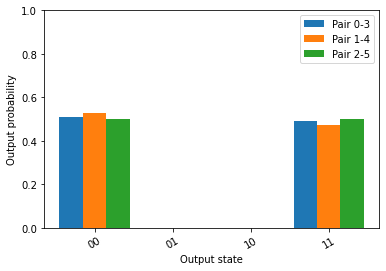

In [9]:
import matplotlib.pyplot as plt
for i in range(3):
    plt.bar([x-0.3+0.3*i for x in range(4)],prsq[i],width=0.3,label="Pair "+str(i)+"-"+str(i+3))

plt.ylim([0,1])
plt.xticks(range(4), [bin(x)[2:].zfill(2) for x in range(4)],rotation=30)
plt.ylabel("Output probability")
plt.xlabel("Output state")
plt.legend()

Text(0.5, 0, 'Qubit')

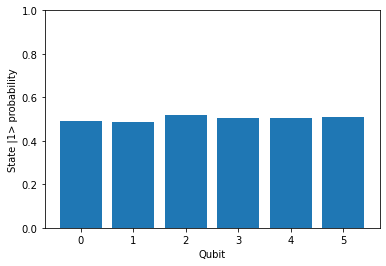

In [10]:
plt.bar(range(6),prbi)
plt.ylim([0,1])
plt.ylabel("State |1> probability")
plt.xlabel("Qubit")

### Running jobs on a quantum computer

We are now ready to submit the jobs on IonQ's QPUs. Since actual quantum computers are noisy, the quality of XX gates on different ions may differ from the ideal and from each other.

In [11]:
# Switch the backend to run circuits on a quantum computer
qpu_backend = provider.get_backend("ionq_qpu")

jobs = run_jobs(qpu_backend,circs,1000)

The job will queue, and results will arrive once it's executed!

In [16]:
#Check if jobs are done
for i in range(len(jobs)):
    print(jobs[i].status())

JobStatus.DONE
JobStatus.DONE


In [17]:
# Fetch the result
results = get_jobs(jobs,1000)
prsq_m = [get_pair(results[0],[i,i+3]) for i in range(3)]
prbi_m = [get_ion(results[1],i) for i in range(6)]

{'0x0': 113, '0x1': 6, '0x2': 11, '0x3': 2, '0x4': 3, '0x6': 2, '0x8': 10, '0x9': 102, '0xb': 6, '0xd': 1, '0xf': 4, '0x10': 3, '0x12': 86, '0x13': 3, '0x16': 6, '0x18': 1, '0x19': 6, '0x1a': 6, '0x1b': 109, '0x1d': 4, '0x1f': 5, '0x20': 3, '0x24': 99, '0x25': 12, '0x26': 8, '0x27': 1, '0x29': 4, '0x2c': 3, '0x2d': 108, '0x2e': 1, '0x2f': 9, '0x31': 1, '0x32': 4, '0x33': 3, '0x34': 4, '0x36': 107, '0x37': 5, '0x39': 3, '0x3b': 6, '0x3d': 3, '0x3e': 5, '0x3f': 122}
[0.113, 0.006, 0.011, 0.002, 0.003, 0, 0.002, 0, 0.01, 0.102, 0, 0.006, 0, 0.001, 0, 0.004, 0.003, 0, 0.086, 0.003, 0, 0, 0.006, 0, 0.001, 0.006, 0.006, 0.109, 0, 0.004, 0, 0.005, 0.003, 0, 0, 0, 0.099, 0.012, 0.008, 0.001, 0, 0.004, 0, 0, 0.003, 0.108, 0.001, 0.009, 0, 0.001, 0.004, 0.003, 0.004, 0, 0.107, 0.005, 0, 0.003, 0, 0.006, 0, 0.003, 0.005, 0.122]
{'0x0': 22, '0x1': 1, '0x2': 9, '0x3': 43, '0x4': 1, '0x5': 23, '0x6': 31, '0x7': 13, '0x9': 16, '0xa': 24, '0xb': 3, '0xc': 24, '0xd': 3, '0xe': 4, '0xf': 24, '0x10': 2, 

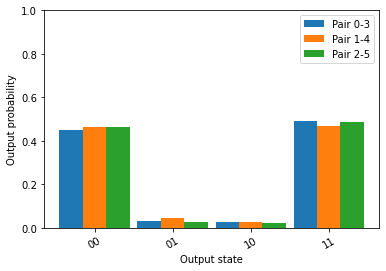

In [18]:
for i in range(3):
    plt.bar([x-0.3+0.3*i for x in range(4)],prsq_m[i],width=0.3,label="Pair "+str(i)+"-"+str(i+3))

plt.ylim([0,1])
plt.xticks(range(4), [bin(x)[2:].zfill(2) for x in range(4)],rotation=30)
plt.ylabel("Output probability")
plt.xlabel("Output state")
plt.legend()

Text(0.5, 0, 'Qubit')

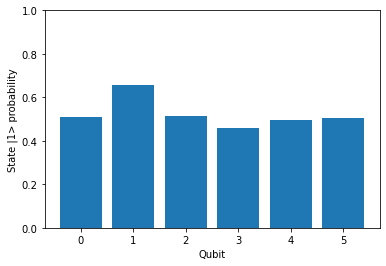

In [19]:
plt.bar(range(6),prbi_m)
plt.ylim([0,1])
plt.ylabel("State |1> probability")
plt.xlabel("Qubit")